In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
%matplotlib inline


### chinook.db schema:
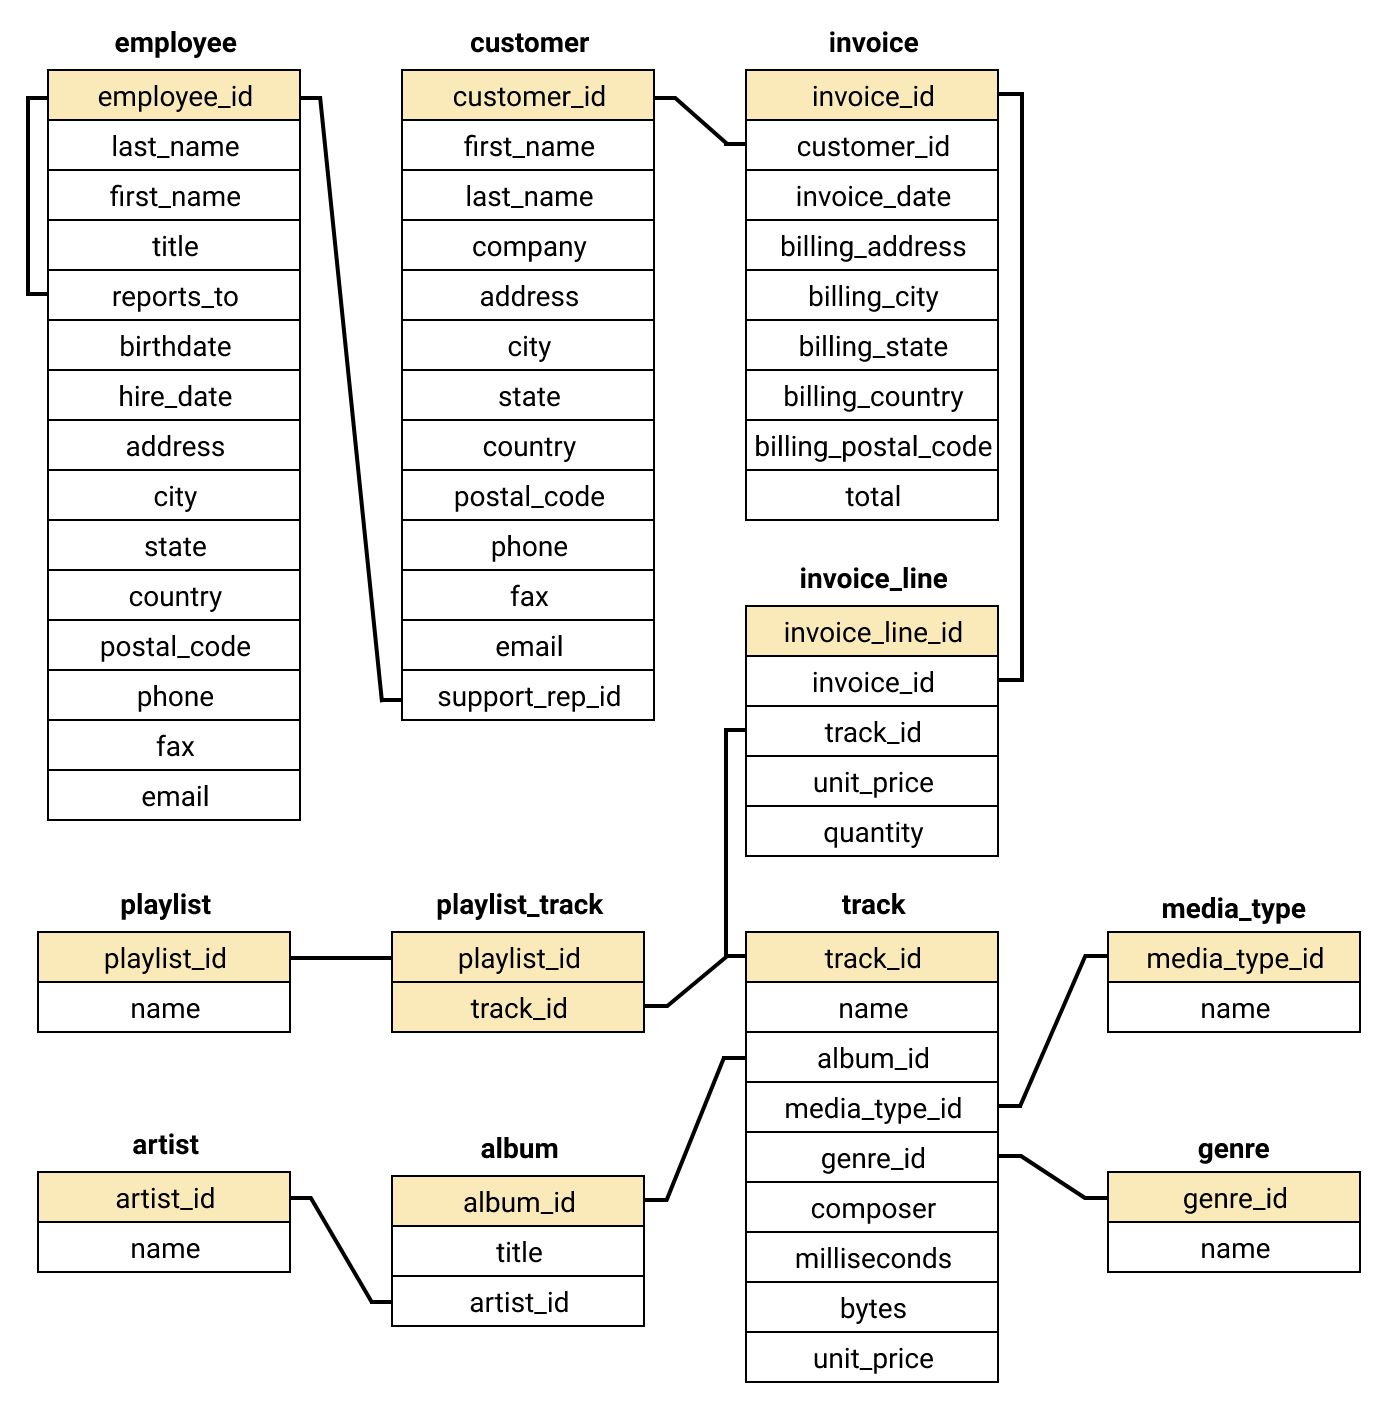

In [2]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [3]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

 * sqlite:///chinook.db
Done.


[('album', 'table'),
 ('artist', 'table'),
 ('customer', 'table'),
 ('employee', 'table'),
 ('genre', 'table'),
 ('invoice', 'table'),
 ('invoice_line', 'table'),
 ('media_type', 'table'),
 ('playlist', 'table'),
 ('playlist_track', 'table'),
 ('track', 'table'),
 ('album_artist_genre', 'view')]

### Top Genres in the USA

In [4]:
%%sql
SELECT DISTINCT(gt.name) genre_name,
COUNT(il.quantity) quantity_sold, 
ROUND(CAST(COUNT(il.quantity) AS FLOAT)/(SELECT SUM(il.quantity) FROM invoice_line il) * 100, 2) || '%' '%_of_sales_qty'
FROM genre gt
INNER JOIN track t ON t.genre_id = gt.genre_id
INNER JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
INNER JOIN customer c ON c.customer_id = i.customer_id
WHERE c.country = 'USA'
GROUP BY 1 ORDER BY 2 DESC
LIMIT 10;

 * sqlite:///chinook.db
Done.


[('Rock', 561, '11.79%'),
 ('Alternative & Punk', 130, '2.73%'),
 ('Metal', 124, '2.61%'),
 ('R&B/Soul', 53, '1.11%'),
 ('Blues', 36, '0.76%'),
 ('Alternative', 35, '0.74%'),
 ('Pop', 22, '0.46%'),
 ('Latin', 22, '0.46%'),
 ('Hip Hop/Rap', 20, '0.42%'),
 ('Jazz', 14, '0.29%')]

## These are the top 3 genre's by sales quantity in the USA.
_`Rock`_ has a very distinct lead over the rest. Assuming that there isn't a pricing difference between genres, focus on these top 3 (in terms of sales quantity).
1. _`Rock`_
2. _`Alternative & Punk`_
3. _`Metal`_  
  
Internationally is even more skewed towards _`Rock`_.

In [5]:
%%sql
SELECT DISTINCT(gt.name) genre_name,
COUNT(il.quantity) quantity_sold, 
ROUND(CAST(COUNT(il.quantity) AS FLOAT)/(SELECT SUM(il.quantity) FROM invoice_line il) * 100, 2) || '%' '%_of_sales_qty'
FROM genre gt
INNER JOIN track t ON t.genre_id = gt.genre_id
INNER JOIN invoice_line il ON il.track_id = t.track_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
INNER JOIN customer c ON c.customer_id = i.customer_id
GROUP BY 1 ORDER BY 2 DESC
LIMIT 3;

 * sqlite:///chinook.db
Done.


[('Rock', 2635, '55.39%'),
 ('Metal', 619, '13.01%'),
 ('Alternative & Punk', 492, '10.34%')]

In [6]:
%%sql
SELECT ar.name artist, al.title,
       SUM(il.quantity) quantity_sold, 
       ROUND(CAST(SUM(il.quantity) AS FLOAT)/
            (SELECT SUM(il.quantity) FROM invoice_line il) * 100, 2) || '%' '%_of_sales_qty'
FROM genre gt
    INNER JOIN track t ON t.genre_id = gt.genre_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN album al ON al.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = al.artist_id
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
WHERE c.country = 'USA' AND gt.name = 'Rock'
GROUP BY 1,2 ORDER BY 3 DESC
LIMIT 10;

 * sqlite:///chinook.db
Done.


[('Jimi Hendrix', 'Are You Experienced?', 28, '0.59%'),
 ('Nirvana', 'From The Muddy Banks Of The Wishkah [live]', 28, '0.59%'),
 ('The Doors', 'The Doors', 27, '0.57%'),
 ('The Rolling Stones', 'Hot Rocks, 1964-1971 (Disc 1)', 25, '0.53%'),
 ("Guns N' Roses", 'Use Your Illusion I', 23, '0.48%'),
 ('Alice In Chains', 'Facelift', 21, '0.44%'),
 ('Scorpions', '20th Century Masters - The Millennium Collection: The Best of Scorpions', 21, '0.44%'),
 ('Van Halen', 'The Best Of Van Halen, Vol. I', 21, '0.44%'),
 ('Pearl Jam', 'Live On Two Legs [live]', 19, '0.4%'),
 ('AC/DC', 'For Those About To Rock We Salute You', 16, '0.34%')]

### Top 10 selling albums for USA customers

In [7]:
%%sql
SELECT al.title album_title,
        SUM(il.quantity) total_sold,
        ar.name artist,
        gt.name genre,
        ROUND(CAST(SUM(il.quantity) AS FLOAT)/
            (SELECT SUM(il.quantity) FROM invoice_line il) * 100, 2) || '%' '%_of_sales_qty'
FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre gt ON gt.genre_id = t.genre_id
    INNER JOIN album al ON al.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = al.artist_id
WHERE country = 'USA'
GROUP BY album_title ORDER BY total_sold DESC
LIMIT 10;

 * sqlite:///chinook.db
Done.


[('From The Muddy Banks Of The Wishkah [live]', 28, 'Nirvana', 'Rock', '0.59%'),
 ('Are You Experienced?', 28, 'Jimi Hendrix', 'Rock', '0.59%'),
 ('The Doors', 27, 'The Doors', 'Rock', '0.57%'),
 ('Seek And Shall Find: More Of The Best (1963-1981)', 26, 'Marvin Gaye', 'R&B/Soul', '0.55%'),
 ('The Cream Of Clapton', 25, 'Eric Clapton', 'Blues', '0.53%'),
 ('Hot Rocks, 1964-1971 (Disc 1)', 25, 'The Rolling Stones', 'Rock', '0.53%'),
 ('Green', 25, 'R.E.M.', 'Alternative & Punk', '0.53%'),
 ('Use Your Illusion I', 23, "Guns N' Roses", 'Rock', '0.48%'),
 ('Mezmerize', 22, 'System Of A Down', 'Metal', '0.46%'),
 ('The Best Of Van Halen, Vol. I', 21, 'Van Halen', 'Rock', '0.44%')]

Based off of these top 10 albums the spread between \#1 and \#7 is only 3 sales, any combination of the top 7 are solid picks in terms of artist popularity (see below), and album popularity.  
My recommendation would be to go with each of the top 7. This would provide for some variety between 4 genres (which are in the top 5 Genres for the USA).  
  
If you want only 3 and want some genre variety The Cream Of Clapton	Hot Rocks (_Blues_), Hot Rocks, 1964-1971 (Disc 1) (_Rock_), and Green (_Alternative & Punk_)  
  
Of course if you would like to stick with the most popular genre the top 3 are all _`Rock`_. Also, internationally _Are You Experienced?_ by Jimi Hendrix is the top album sold world wide, and he is the 2nd most popular artist world wide as well.

In [8]:
%%sql
SELECT ar.name artist,
        SUM(il.quantity) total_sold,
        gt.name genre,
        ROUND(CAST(SUM(il.quantity) AS FLOAT)/
            (SELECT SUM(il.quantity) FROM invoice_line il) * 100, 2) || '%' '%_of_sales_qty'
FROM invoice_line il
    INNER JOIN invoice i ON i.invoice_id = il.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN genre gt ON gt.genre_id = t.genre_id
    INNER JOIN album al ON al.album_id = t.album_id
    INNER JOIN artist ar ON ar.artist_id = al.artist_id
WHERE c.country = 'USA'
GROUP BY artist ORDER BY total_sold DESC
LIMIT 10;

 * sqlite:///chinook.db
Done.


[('Van Halen', 43, 'Rock', '0.9%'),
 ('R.E.M.', 38, 'Alternative & Punk', '0.8%'),
 ('The Rolling Stones', 37, 'Rock', '0.78%'),
 ('Nirvana', 35, 'Rock', '0.74%'),
 ('Foo Fighters', 34, 'Rock', '0.71%'),
 ('Eric Clapton', 34, 'Blues', '0.71%'),
 ("Guns N' Roses", 32, 'Rock', '0.67%'),
 ('Green Day', 32, 'Alternative & Punk', '0.67%'),
 ('Pearl Jam', 31, 'Alternative & Punk', '0.65%'),
 ('Amy Winehouse', 30, 'R&B/Soul', '0.63%')]

## Sales analysis by sales rep

In [9]:
%%sql
--Sales by rep for the first year (varied start dates)

WITH sales_reps AS (
            SELECT * FROM employee
            WHERE title = 'Sales Support Agent'
            )
SELECT sr.first_name || ' ' || sr.last_name name,
       '$' || ROUND(SUM(i.total)) sales_dollars,
       ROUND(SUM(i.total) / 
             (SELECT SUM(i.total) FROM invoice i) * 100, 2) || '%' percent_of_total,
       STRFTIME('%m-%d-%Y', sr.hire_date) hire_date,
       (CAST(STRFTIME('%m', '12') AS INT) - 
             CAST(STRFTIME('%m', sr.hire_date) AS INT)) || ' months' service_thru_EOY,
        ROUND(SUM(i.total) / (CAST(STRFTIME('%m', '12') AS INT) - 
             CAST(STRFTIME('%m', sr.hire_date) AS INT)), 2) sales_per_month_2017 
FROM sales_reps sr
    INNER JOIN customer c ON c.support_rep_id = sr.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
WHERE i.invoice_date LIKE '2017%'
GROUP BY sr.employee_id ORDER BY 2 DESC
    

 * sqlite:///chinook.db
Done.


[('Jane Peacock', '$533.0', '11.31%', '04-01-2017', '8 months', 66.58),
 ('Margaret Park', '$417.0', '8.85%', '05-03-2017', '7 months', 59.54),
 ('Steve Johnson', '$252.0', '5.36%', '10-17-2017', '2 months', 126.22)]

In [10]:
%%sql
-- Sales by rep for the year of 2018
WITH sales_reps AS (
            SELECT * FROM employee
            WHERE title = 'Sales Support Agent'
            )
SELECT sr.first_name || ' ' || sr.last_name name,
       '$' || ROUND(SUM(i.total)) sales_dollars,
       ROUND(SUM(i.total) / 12, 2) sales_per_month_2018
FROM sales_reps sr
    INNER JOIN customer c ON c.support_rep_id = sr.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
WHERE i.invoice_date LIKE '2018%'
GROUP BY 1 ORDER BY 2 DESC

 * sqlite:///chinook.db
Done.


[('Jane Peacock', '$414.0', 34.49),
 ('Margaret Park', '$401.0', 33.41),
 ('Steve Johnson', '$333.0', 27.72)]

In [11]:
%%sql
-- Sales by rep for the year of 2019
WITH sales_reps AS (
            SELECT * FROM employee
            WHERE title = 'Sales Support Agent'
            )
SELECT sr.first_name || ' ' || sr.last_name name,
       '$' || ROUND(SUM(i.total)) sales_dollars,
       ROUND(SUM(i.total) / 12, 2) sales_per_month_2019
FROM sales_reps sr
    INNER JOIN customer c ON c.support_rep_id = sr.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
WHERE i.invoice_date LIKE '2019%'
GROUP BY 1 ORDER BY 2 DESC

 * sqlite:///chinook.db
Done.


[('Steve Johnson', '$438.0', 36.47),
 ('Margaret Park', '$401.0', 33.41),
 ('Jane Peacock', '$383.0', 31.93)]

In [12]:
%%sql
-- Monthly sales per rep
WITH sales_reps AS (
            SELECT * FROM employee
            WHERE title = 'Sales Support Agent'
            )
SELECT sr.first_name || ' ' || sr.last_name name,
       '$' || ROUND(SUM(i.total)) sales_dollars,
       ROUND(SUM(i.total) / (12 * (STRFTIME('%Y', MAX(i.invoice_date)) - STRFTIME('%Y', MIN(i.invoice_date)))) - 
             CAST(STRFTIME('%m', sr.hire_date) AS INT), 2) sales_per_month
FROM sales_reps sr
    INNER JOIN customer c ON c.support_rep_id = sr.employee_id
    INNER JOIN invoice i ON i.customer_id = c.customer_id
--WHERE i.invoice_date LIKE '2019%'
GROUP BY 1 ORDER BY 2 DESC

 * sqlite:///chinook.db
Done.


[('Jane Peacock', '$1732.0', 44.1),
 ('Margaret Park', '$1584.0', 39.0),
 ('Steve Johnson', '$1394.0', 28.72)]

## Each reps sales broken down by year shows drop-off from year 1
2017 by far was a better year for all 3 reps, and as you can see the next 2 years were rather stagnant. The last table

In [13]:
%%sql

SELECT sr.first_name,
ROUND(SUM(i.total), 2) total
--        ROUND(SUM(i.total) / (CAST(STRFTIME('%m', '24') AS INT) - 
--             CAST(STRFTIME('%m', sr.hire_date) AS INT)), 2) sales_per_month_y1
    FROM invoice i
        INNER JOIN customer c ON c.customer_id = i.customer_id
        INNER JOIN employee sr ON sr.employee_id = c.support_rep_id
        WHERE i.invoice_date > '2018-01-01'
    GROUP BY sr.employee_id

 * sqlite:///chinook.db
Done.


[('Jane', 1198.89), ('Margaret', 1167.21), ('Steve', 1141.47)]

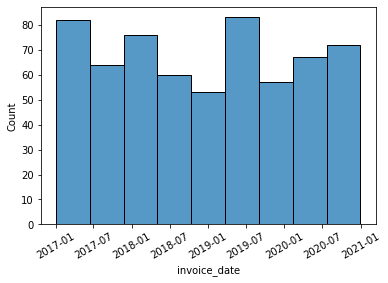

In [94]:
# sqlite3 connection to use with pd
con = sqlite3.connect('chinook.db')
# read SQL query into pd dataframe
invoice_dates = pd.read_sql('SELECT invoice_date FROM invoice', con)

dates = pd.to_datetime(invoice_dates['invoice_date'])
start_date = dates.min()
relative = dates - start_date
invoice_dates['rel'] = relative.astype('timedelta64[D]')

plot1 = sns.histplot(invoice_dates, bins=9, x=dates)
plt.xticks(rotation=30);

## Examining sales by country

In [15]:
%%sql
SELECT  c.country,
        ROUND(SUM(i.total), 2) total_spent,
        COUNT(DISTINCT(c.customer_id)) customer_count,
        ROUND(SUM(i.total) / COUNT(i.customer_id),2) avg_ticket,
        ROUND(SUM(i.total) / COUNT(DISTINCT(i.customer_id)), 2) value_per_customer,
        ROUND(CAST(SUM(i.total) AS FLOAT) / (SELECT SUM(total) FROM invoice)*100, 2) '%_of_total_sales'
FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    GROUP BY 1
    ORDER BY 2 DESC

 * sqlite:///chinook.db
Done.


[('USA', 1040.49, 13, 7.94, 80.04, 22.09),
 ('Canada', 535.59, 8, 7.05, 66.95, 11.37),
 ('Brazil', 427.68, 5, 7.01, 85.54, 9.08),
 ('France', 389.07, 5, 7.78, 77.81, 8.26),
 ('Germany', 334.62, 4, 8.16, 83.66, 7.11),
 ('Czech Republic', 273.24, 2, 9.11, 136.62, 5.8),
 ('United Kingdom', 245.52, 3, 8.77, 81.84, 5.21),
 ('Portugal', 185.13, 2, 6.38, 92.57, 3.93),
 ('India', 183.15, 2, 8.72, 91.58, 3.89),
 ('Ireland', 114.84, 1, 8.83, 114.84, 2.44),
 ('Spain', 98.01, 1, 8.91, 98.01, 2.08),
 ('Chile', 97.02, 1, 7.46, 97.02, 2.06),
 ('Australia', 81.18, 1, 8.12, 81.18, 1.72),
 ('Finland', 79.2, 1, 7.2, 79.2, 1.68),
 ('Hungary', 78.21, 1, 7.82, 78.21, 1.66),
 ('Poland', 76.23, 1, 7.62, 76.23, 1.62),
 ('Sweden', 75.24, 1, 7.52, 75.24, 1.6),
 ('Norway', 72.27, 1, 8.03, 72.27, 1.53),
 ('Austria', 69.3, 1, 7.7, 69.3, 1.47),
 ('Netherlands', 65.34, 1, 6.53, 65.34, 1.39),
 ('Belgium', 60.39, 1, 8.63, 60.39, 1.28),
 ('Italy', 50.49, 1, 5.61, 50.49, 1.07),
 ('Argentina', 39.6, 1, 7.92, 39.6, 0.84),
 ('Denmark', 37.62, 1, 3.76, 37.62, 0.8)]

### The countries that have only 1 customer shouldn't be ignored
Consider #1 Ireland, #3 Chile, and #4 Australia. We could find the population for all the countries to determine the customer potential. However, these 3 countries (among others) have a lot of potential, and are spread out across the globe.


# Purchases Entire Album vs Individual Tracks
Once upon a time there was no way to buy indivual tracks (aside from hit single albums but you couldn't choose the track) you had to buy the entire album on whatever media format was the current standard. So now that you can pick and choose individual tracks but still have the option to purchase an entire album what is the breakdown of individual tracks vs albums. Chinook does not currently allow customers to purchase both on a single transaction. Meaning that you can buy albums or individual tracks on a single transaction. The customer is still buying each individual track but they are grouped together in a single transaction (invoice_id). Essentially this means we need to isolate the invoices that include every track_id from an album_id and no additional track_ids 

In [91]:
%%sql
/*
# This query shows the break down of invoices where the customer purchased a whole album or individual tracks.
*/
WITH invoice_tracks AS (
            SELECT t.album_id,
                   il.track_id,
                   il.invoice_id
            FROM track t
            INNER JOIN invoice_line il ON t.track_id = il.track_id
            GROUP BY il.invoice_id)

SELECT  COUNT(it.invoice_id) count,  /* # counts of each type of purchase */
        ROUND(
            CAST(COUNT(it.invoice_id) AS FLOAT)/
                (SELECT COUNT(invoice_id) FROM invoice)*100, 2) || '%' percent_invoices,
        CASE   /* # Determines whether or not the tracks on an invoice match all the tracks from the album */
        WHEN (SELECT t0.track_id 
              FROM track t0
              WHERE t0.album_id = it.album_id
             EXCEPT
              SELECT il0.track_id
              FROM invoice_line il0
              WHERE il0.invoice_id = it.invoice_id) IS NULL
            AND
             (SELECT il0.track_id
              FROM invoice_line il0
              WHERE il0.invoice_id = it.invoice_id
             EXCEPT
              SELECT t0.track_id 
              FROM track t0
              WHERE t0.album_id = it.album_id) IS NULL
        THEN 'album'
        ELSE 'tracks'
        END purchase_type
FROM invoice_tracks it
GROUP BY purchase_type

 * sqlite:///chinook.db
Done.


[(114, '18.57%', 'album'), (500, '81.43%', 'tracks')]

## Change the way orders can be placed...
I would change the 'checkout process' to allow customers to add on additional tracks to purchases of entire albums. It would __improve the customer experience__ as they wouldn't have to select every track on an album to be able to add individual tracks to their order. It would also __increase the 'average ticket' and decrease the number of transactions.__ Essentially, who says no to incremental sales?